# Prophet

* https://facebook.github.io/prophet/docs/quick_start.html#python-api

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../src')

In [10]:
#!pip install pytorch-common

In [276]:
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import random
import torch

from statsmodels.graphics.tsaplots import plot_pacf

from data   import standarizer, \
                   features_target_split, \
                   train_test_split

from data   import train_test_split

import pytorch_common.util    as pu
from prophet import Prophet

## Setup

In [372]:
CFG = {
    'etherium'         : { 'path': '../datasets/ETH_1H.csv',                 'variable': 'close' },
    'min-temp'         : { 'path': '../datasets/daily-min-temperatures.csv', 'variable': 'temp'  },
    'consumo_GBA'      : { 'path': '../datasets/data3_dia.csv', 'variable': 'mwh'  },
    'dataset'          : 'consumo_GBA',
    'interval_width'   : 0.99, 
    'daily_seasonality': True,
    'times'            : 578#200
}

## Functions

In [67]:
def normalize(train_set, test_set):
    norm_train_set, norm_test_set = standarizer(train_set, test_set, columns=['y'])
    
    norm_train_set = norm_train_set[['ds', 'norm_y']]
    norm_train_set = norm_train_set.rename(columns={'norm_y': 'y' }).sort_values(by='ds',ascending=True)
    
    norm_test_set = norm_test_set[['ds', 'norm_y']]
    norm_test_set = norm_test_set.rename(columns={'norm_y': 'y' }).sort_values(by='ds',ascending=True)

    return norm_train_set, norm_test_set


def select_and_format_columns(dataset, column):
    dataset.columns = dataset.columns.str.lower()
    dataset.rename(columns={dataset.columns[0]: 'date'},inplace=True)
    dataset       = dataset[['date', column]]
    dataset       = dataset.rename(columns={'date': 'ds', column: 'y' })
    dataset['ds'] = pd.to_datetime(dataset['ds'])
    dataset       = dataset.sort_values(by='ds',ascending=True)
    return dataset


def preprocessing(dataset, column, test_percent):
    dataset                       = select_and_format_columns(dataset, column)
    train_set, test_set           = train_test_split(dataset, test_percent = test_percent)
    norm_train_set, norm_test_set = normalize(train_set, test_set)

    print(norm_train_set.shape, norm_test_set.shape)

    return norm_train_set, norm_test_set

In [7]:
def predict(model, y_true_df, times):
    sns.set(rc = {'figure.figsize':(15,8)})

    y_true_df = y_true_df.head(times)

    y_pred_df = model.predict(y_true_df[['ds']])

    predictions_df = y_true_df.merge(y_pred_df, on='ds')
    predictions_df = predictions_df[['ds', 'y', 'yhat']]
    predictions_df = predictions_df.sort_values(by='ds',ascending=True)
    
    plot(
        predictions_df.yhat.values,
        predictions_df.y.values
    )
    model.plot(y_pred_df)

In [8]:
def plot(y_pred, y_true):
    sns.set_style("darkgrid")
    plt.plot(y_true, color='green',label="True")        
    plt.plot(y_pred, color='blue', label="Prediction")
    plt.legend()
    plt.show()

In [80]:
#funciones para ploteo estacional, básico y períodograma
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'

def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax


def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

In [218]:
#lags
def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax


def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig

## Preprocessing

In [183]:
train_set, test_set = preprocessing(
    dataset      = pd.read_csv(CFG[CFG['dataset']]['path']),
    column       = CFG[CFG['dataset']]['variable'],
    test_percent = 0.10095 #.1
)
N_test=len(test_set)

(5144, 2) (578, 2)


In [368]:
train_set.ds #ultimo dia train 31/12/2019

0      2005-12-01
1      2005-12-02
2      2005-12-03
3      2005-12-04
4      2005-12-05
          ...    
5139   2019-12-27
5140   2019-12-28
5141   2019-12-29
5142   2019-12-30
5143   2019-12-31
Name: ds, Length: 5144, dtype: datetime64[ns]

Text(0.5, 1.0, 'test 2006-2019')

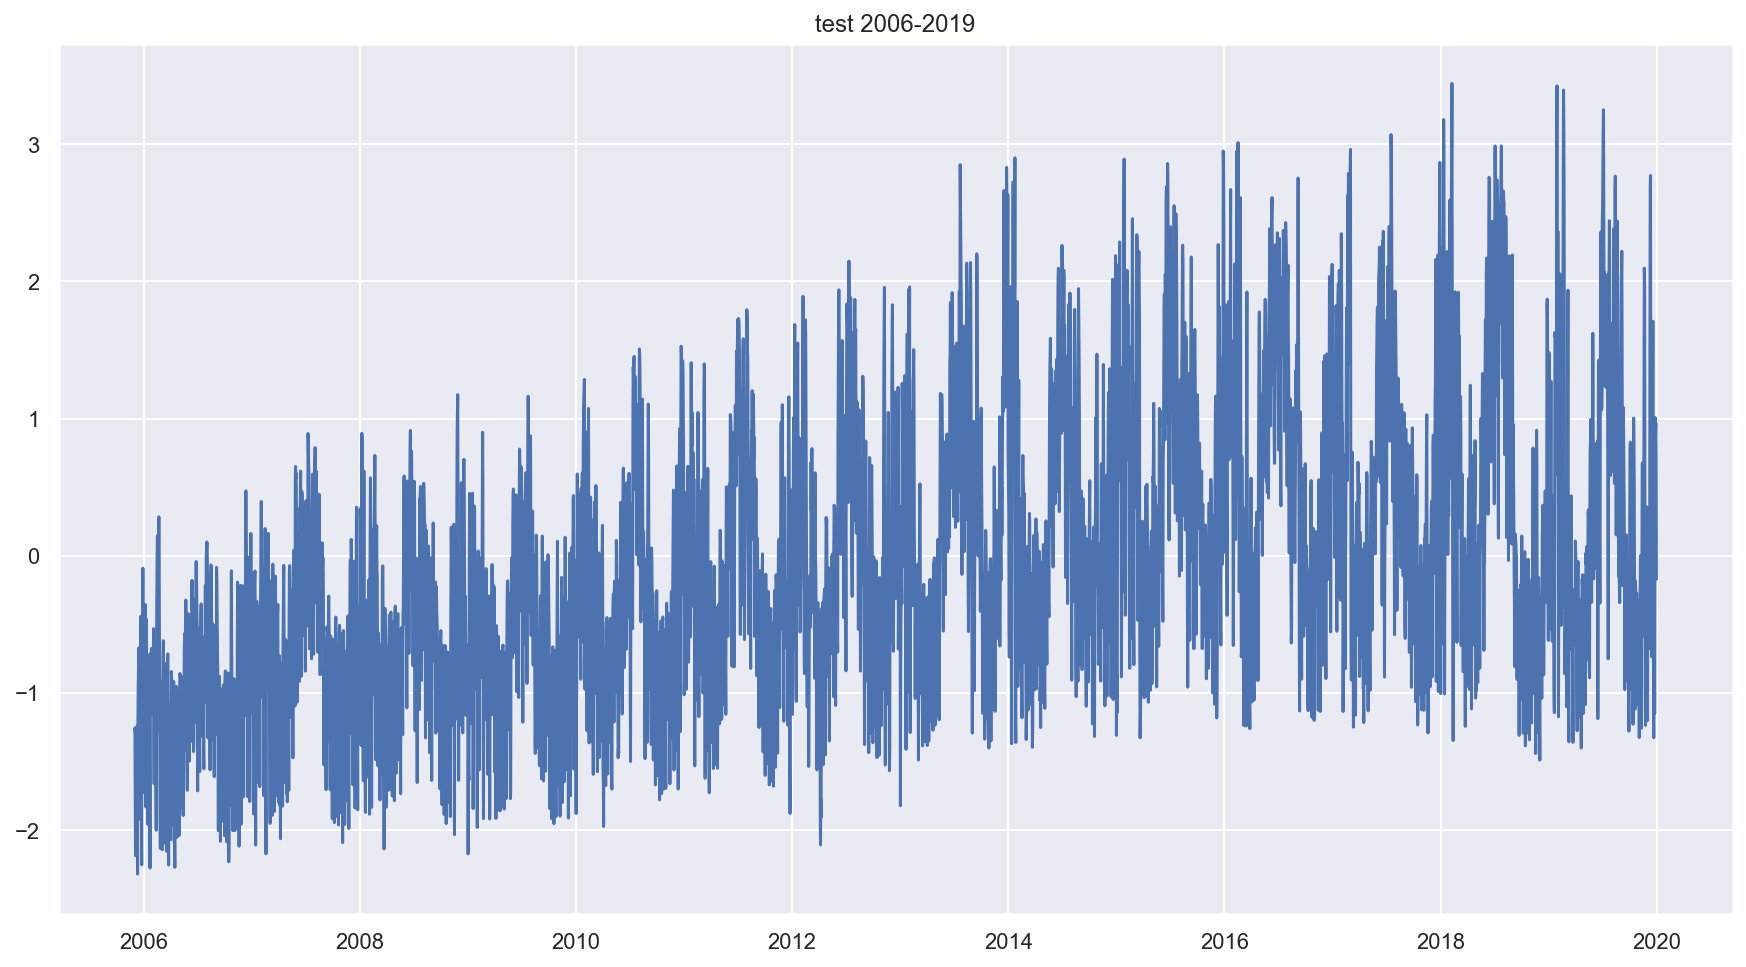

In [369]:
plt.plot(train_set.ds,train_set.y)
plt.title('test 2006-2019')

Text(0.5, 1.0, 'test 2020-2021')

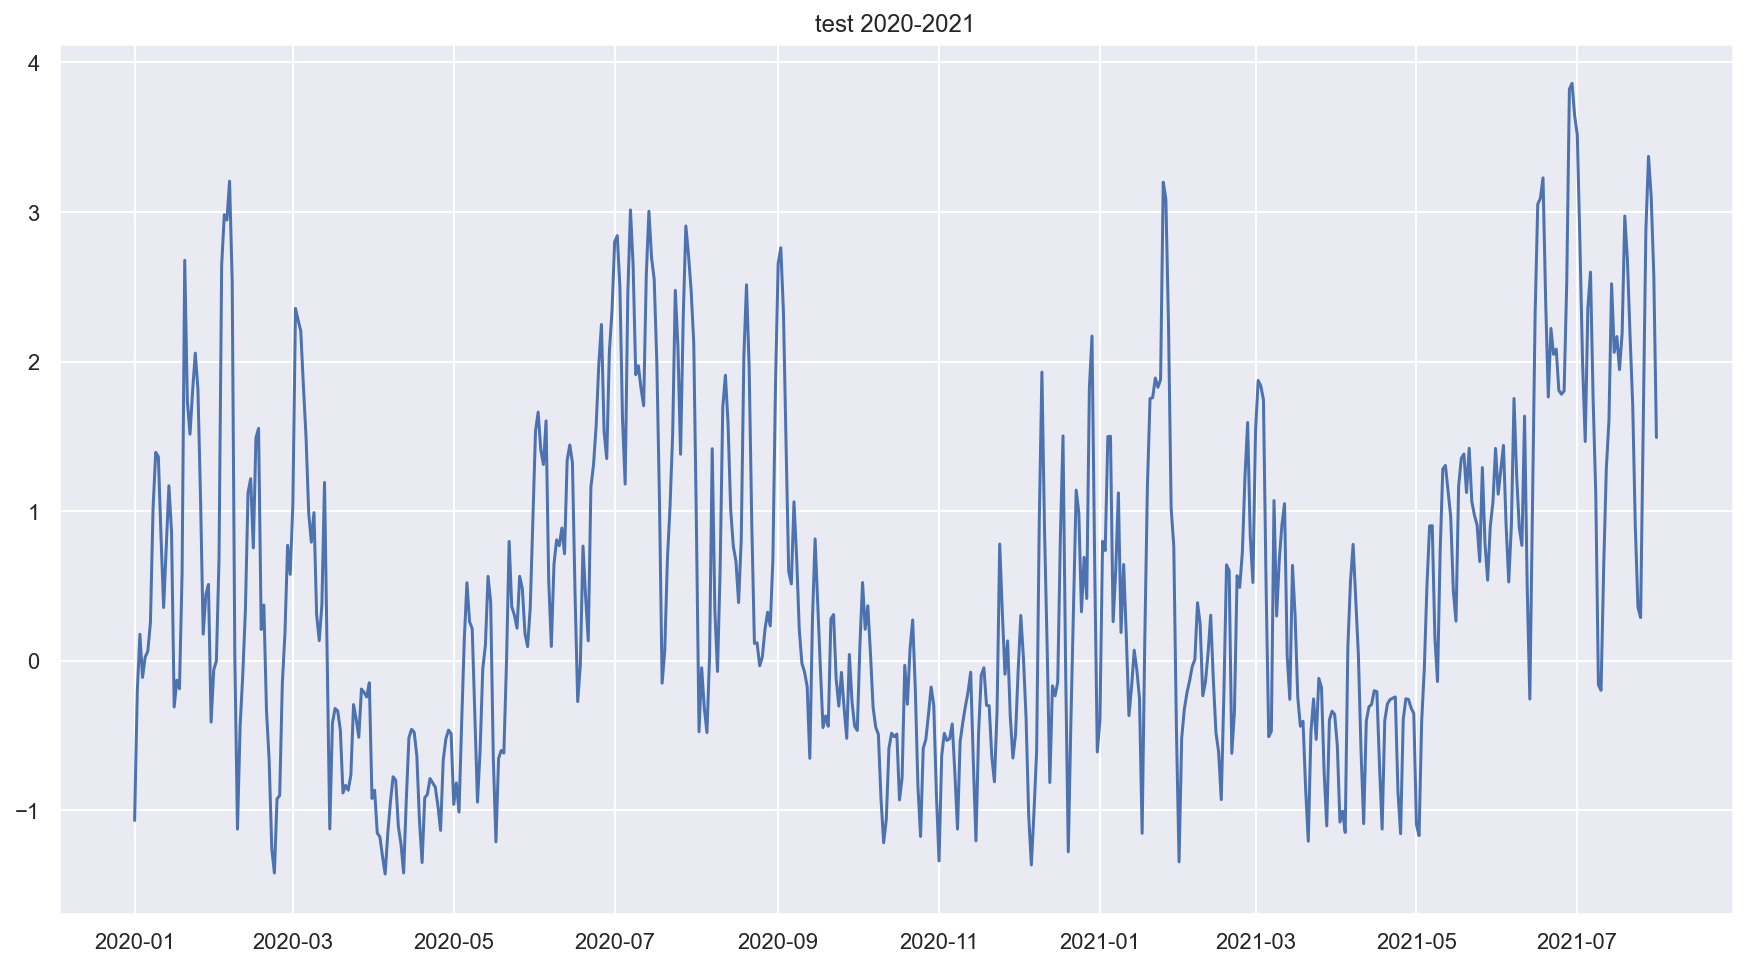

In [370]:
plt.plot(test_set.ds,test_set.y)
plt.title('test 2020-2021')

## Análisis de estacionalidad

referencias de las siguientes funciones: https://www.kaggle.com/learn/time-series

### Trend

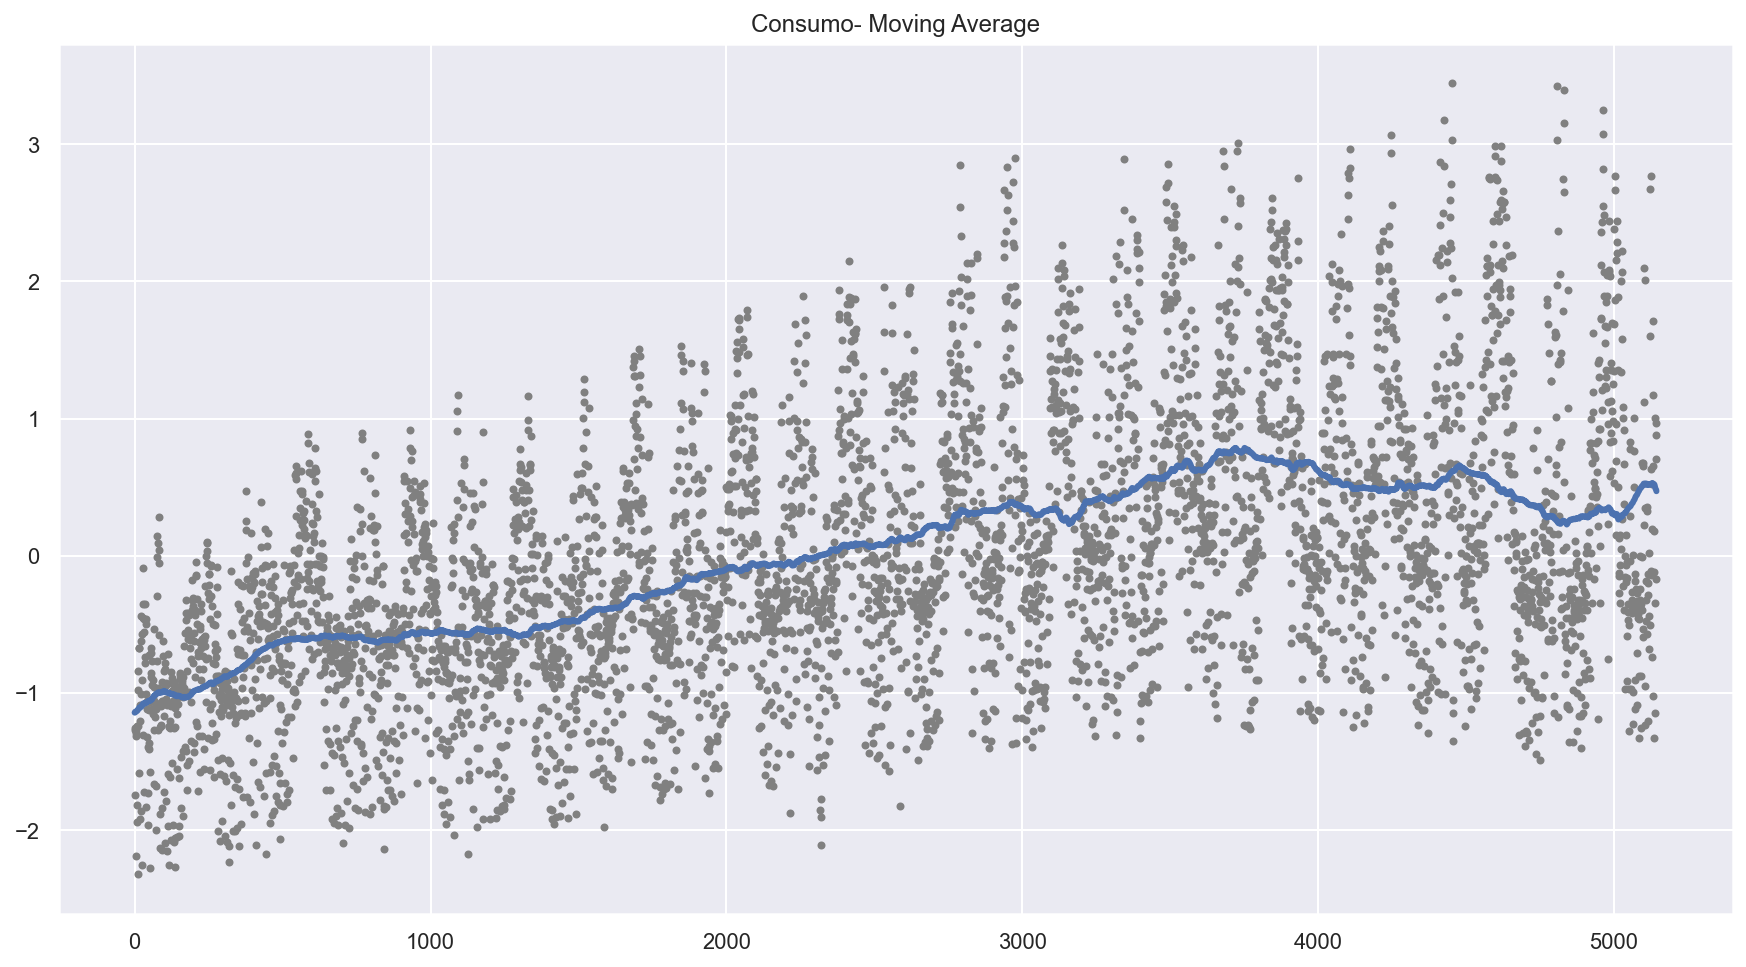

In [371]:
moving_average = train_set.y.rolling(
    window=365,       # 365-day window
    center=True,      # puts the average at the center of the window
    min_periods=183,  # choose about half the window size
).mean()              # compute the mean (could also do median, std, min, max, ...)

ax = train_set.y.plot(style=".", color="0.5")
moving_average.plot(
    ax=ax, linewidth=3, title="Consumo- Moving Average", legend=False,
);

### Seasonality

In [279]:
X = train_set.copy()

X['date'] = pd.to_datetime(X['ds'])
X['year'] = X['date'].dt.year
X['month'] = X['date'].dt.month
X['week'] = X['date'].dt.isocalendar().week
X['day_month'] = X['date'].dt.day
X['day_year'] = X['date'].dt.dayofyear 
X['day'] = X['date'].dt.dayofweek 
#X['weekend']=(X['day_week']>5).astype(int)
#X['friday']=(X['day_week']==4).astype(int)
#X["week"] = X.index.week
bins = [0, 91, 183, 275, 366]  #estaciones
labels=['Winter', 'Spring', 'Summer', 'Fall'] #hemisferio norte
labels=['Summer', 'Fall','Winter', 'Spring'] #hemisferio sur
doy = X.day_year
X['season'] = pd.cut(doy + 11 - 366*(doy > 355), bins=bins, labels=labels)

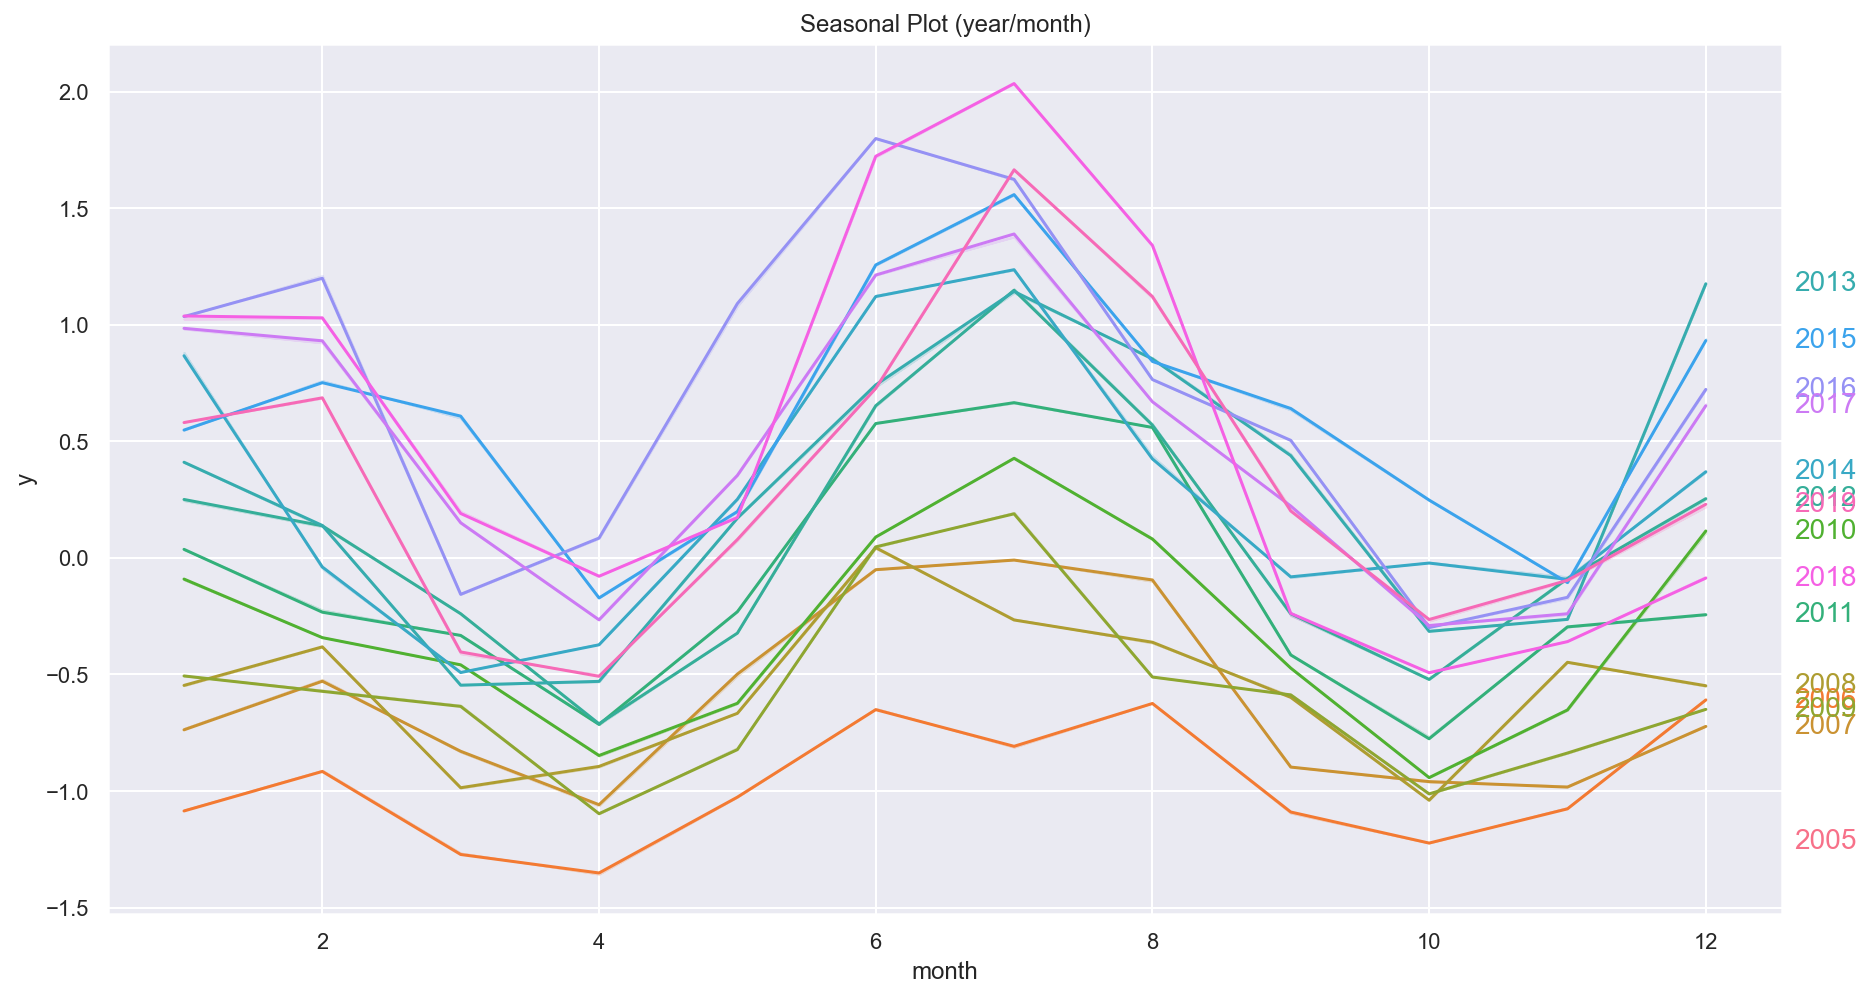

In [214]:
seasonal_plot(X, y='y', period='year', freq='month');

C:\Users\flavi\AppData\Local\Temp\ipykernel_21196\3699215712.py:1: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  plot_periodogram(X.y);


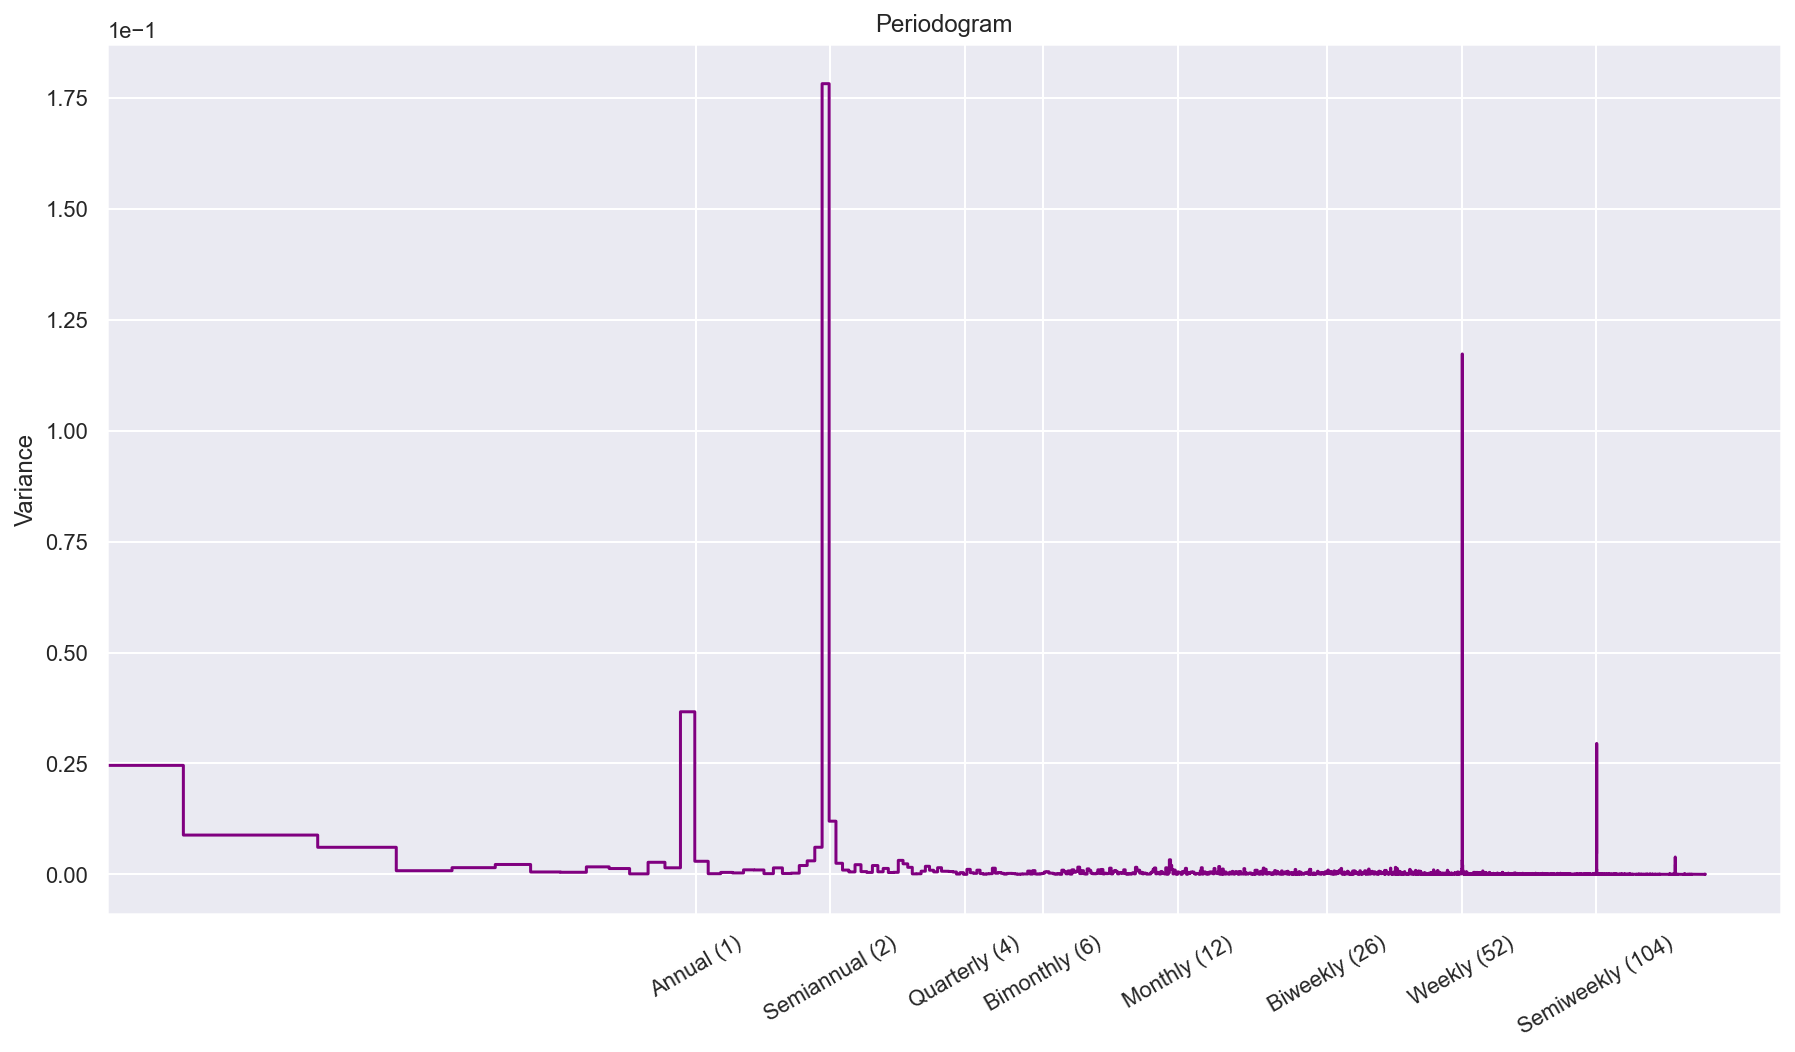

In [215]:
plot_periodogram(X.y);

En el periodgrama se ve un pico máximo en la frecuencia semianual, la segunda componente es bisemanal (cada 2 semanas).

In [277]:
#medians = X.groupby(['year','month']).y.median()
#medians

#X.season.values.value_counts()

### Lags

In [280]:
#X.reset_index(inplace=True)
X.set_index(
    pd.PeriodIndex(X.date, freq="W"),
    inplace=True,
)
X.drop("date", axis=1, inplace=True)

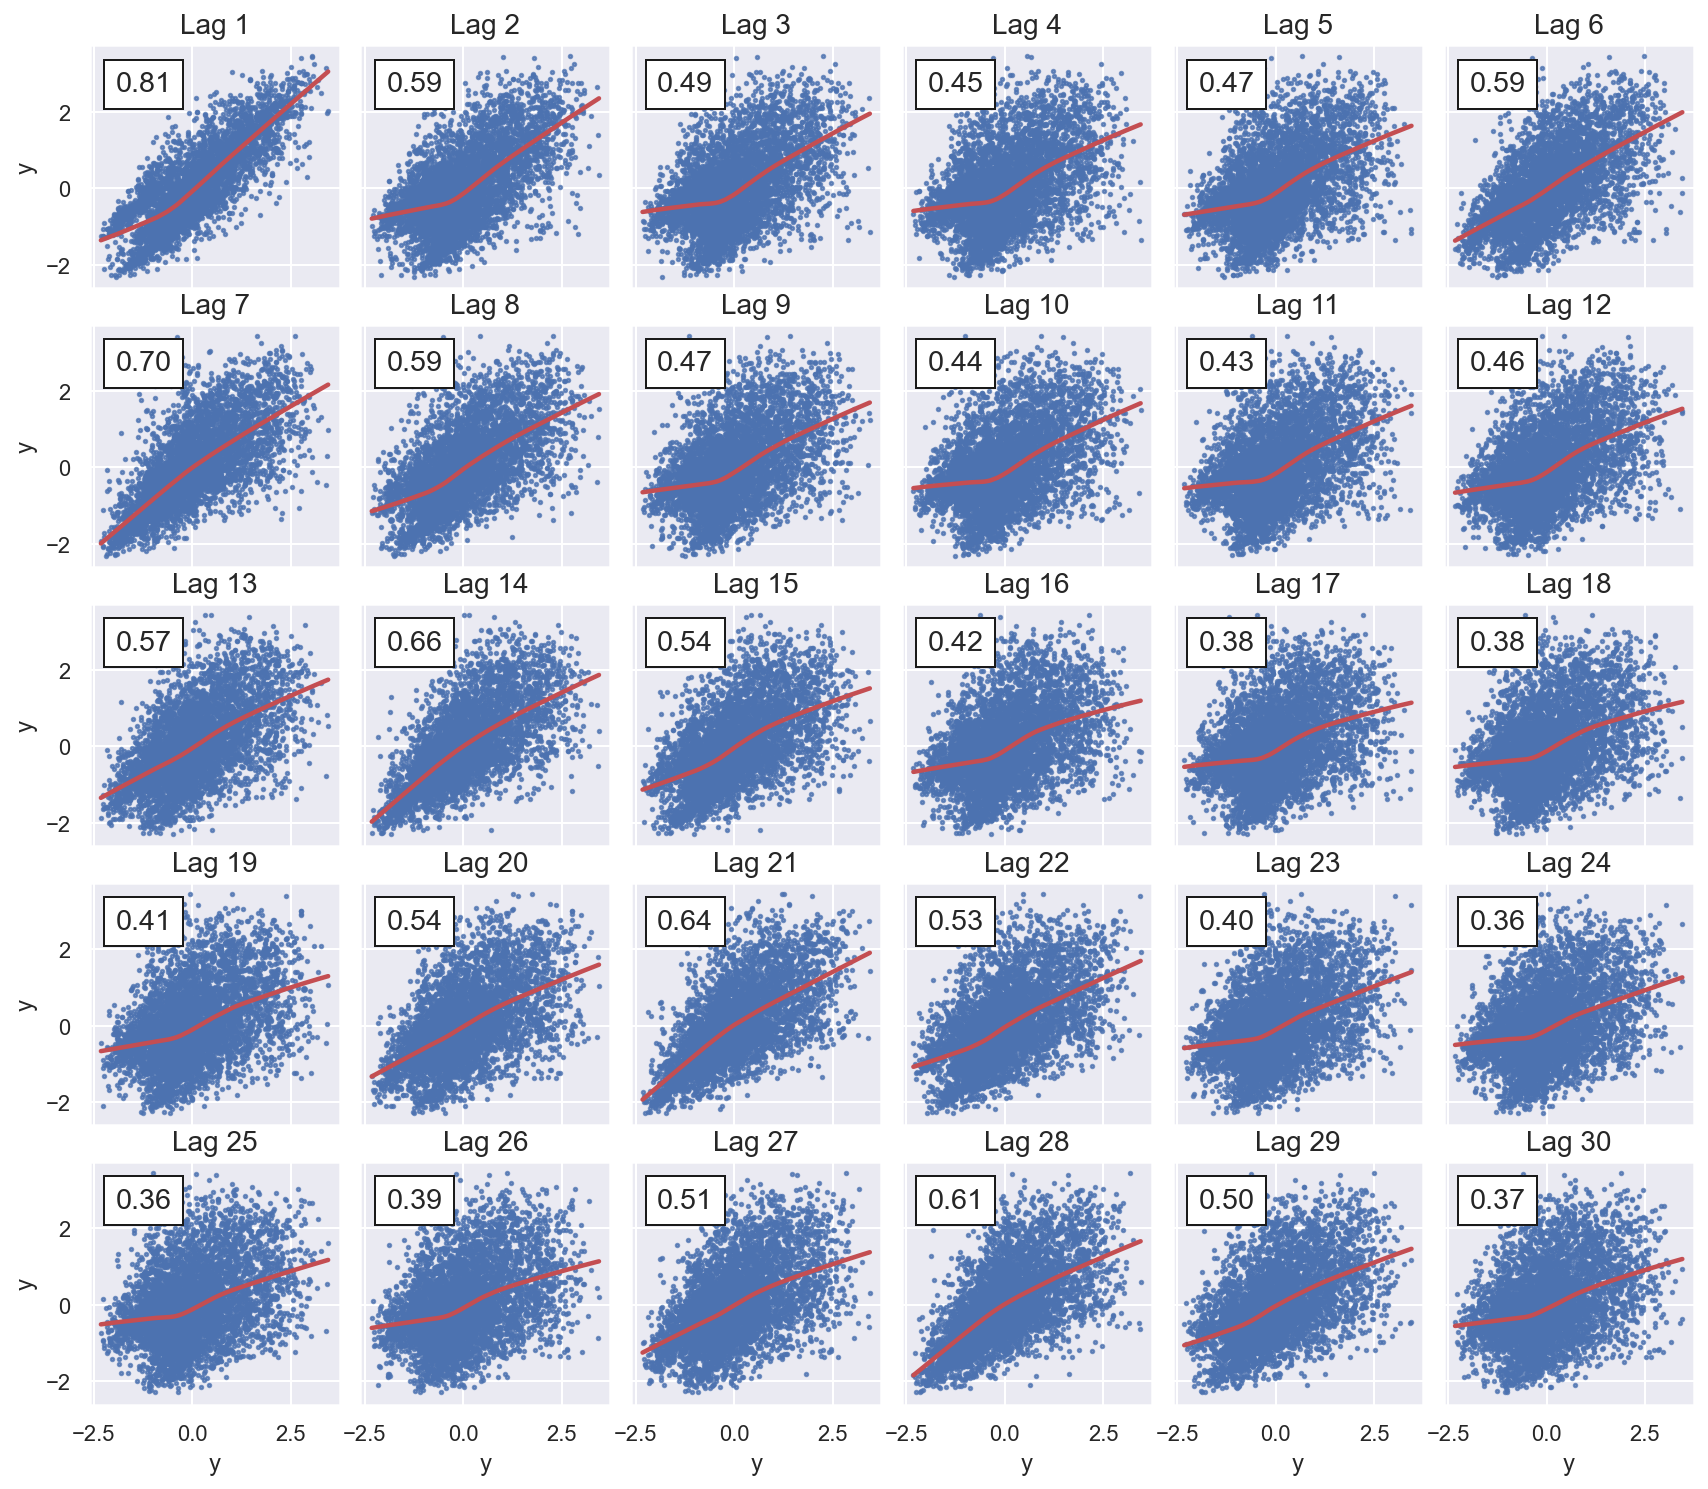

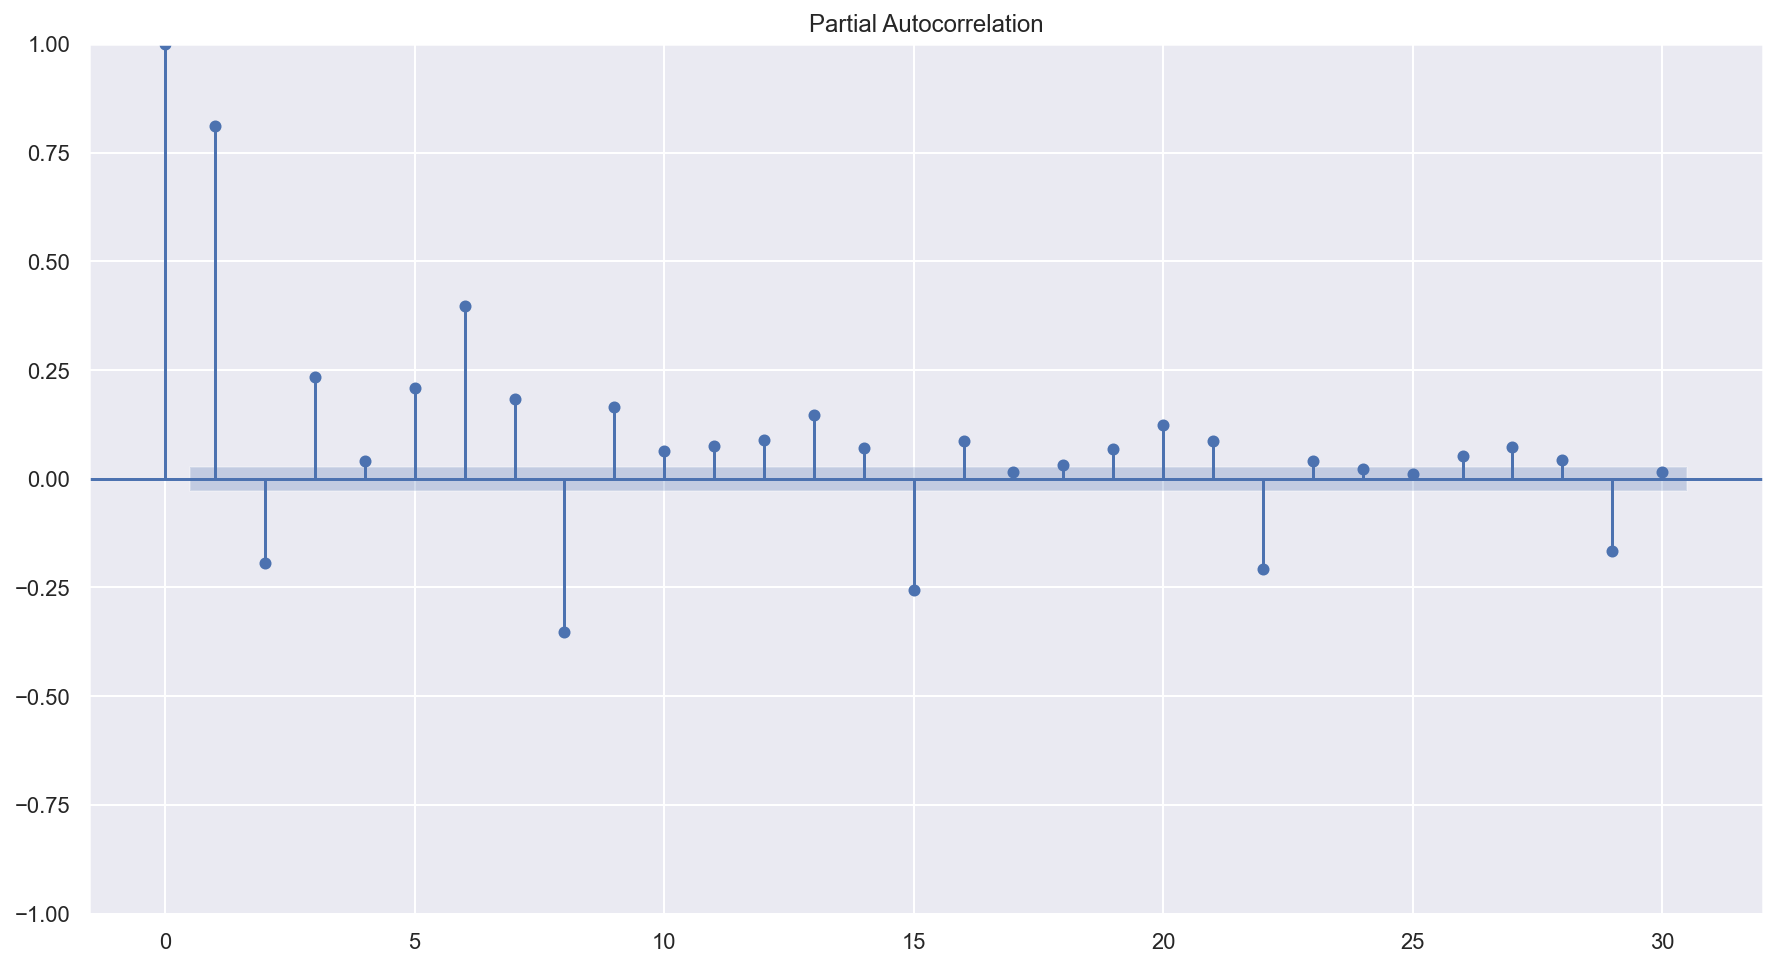

In [283]:
_ = plot_lags(X.y, lags=30, nrows=5)
_ = plot_pacf(X.y, lags=30)

Los lag plots indican que la relación de y con sus lags es mayormente linear. La autocorrelation parcial es alta en lag 1, 6, 8, 15, 22,28

# Model Definition

00:48:59 - cmdstanpy - INFO - Chain [1] start processing
00:49:00 - cmdstanpy - INFO - Chain [1] done processing


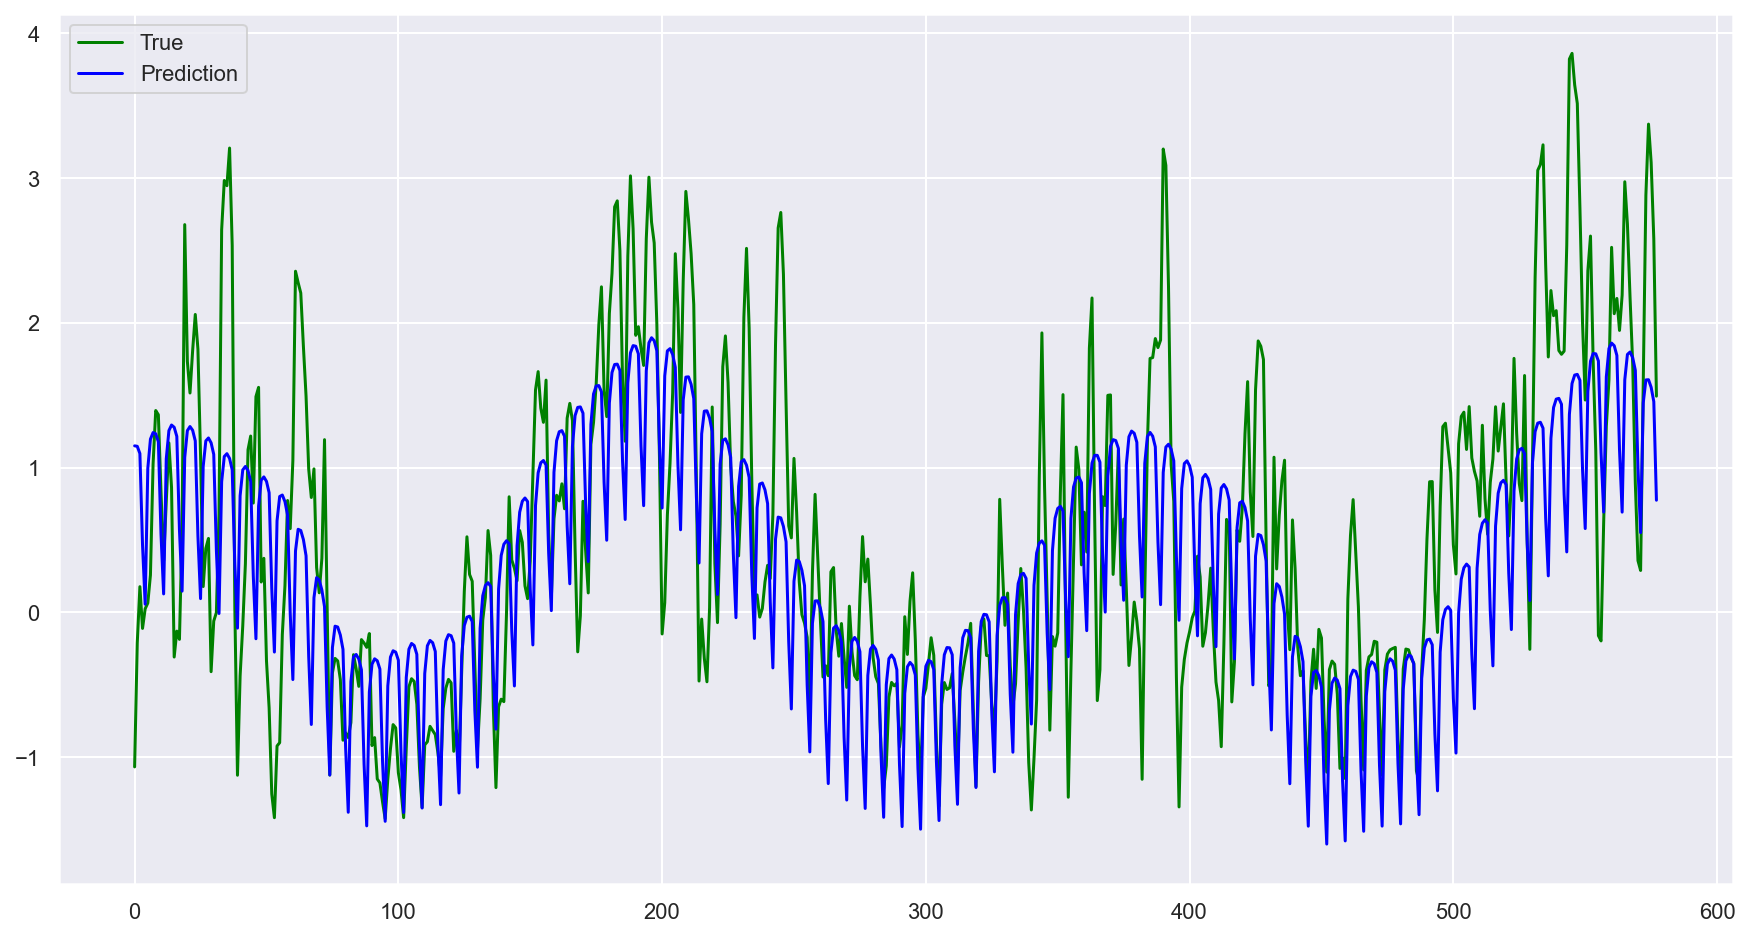

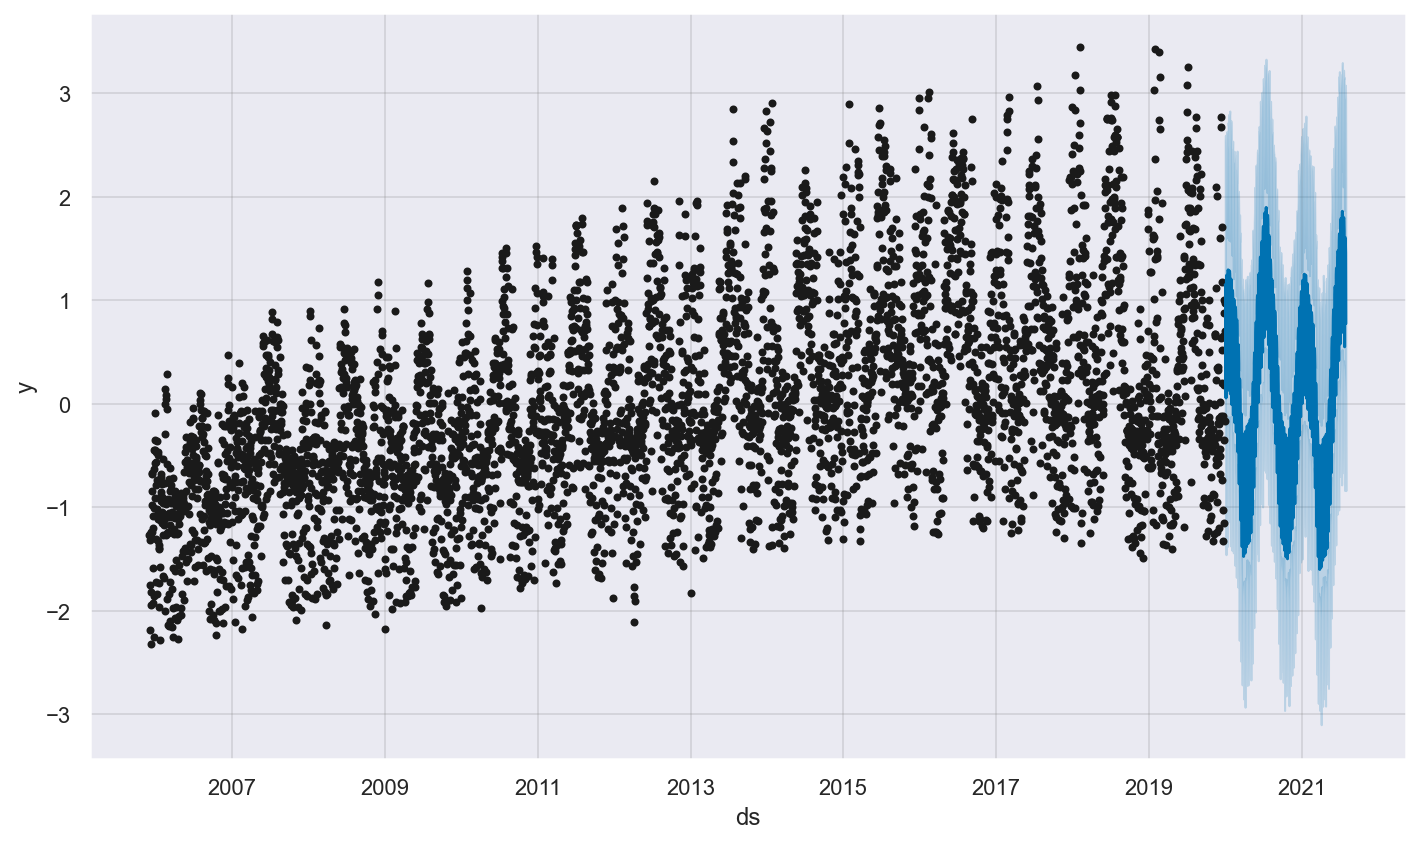

In [376]:
model = Prophet(
    interval_width    = CFG['interval_width'],
    #daily_seasonality = CFG['daily_seasonality'],
)
model.add_seasonality(name='weekly', period=7, fourier_order=4)
#model.add_seasonality(name='semi-weekly', period=3.5, fourier_order=4)
#model.add_seasonality('quarterly', period=91.25, fourier_order=8, mode='additive')
model.add_seasonality('semi-annualy', period=182.5, fourier_order=4, mode='additive')

#model.add_regressor('regressor', mode='additive')
#model.add_seasonality(name='anual',period=365,fourier_order=4)
model.fit(train_set)

fig=predict(model, test_set, times=CFG['times'])

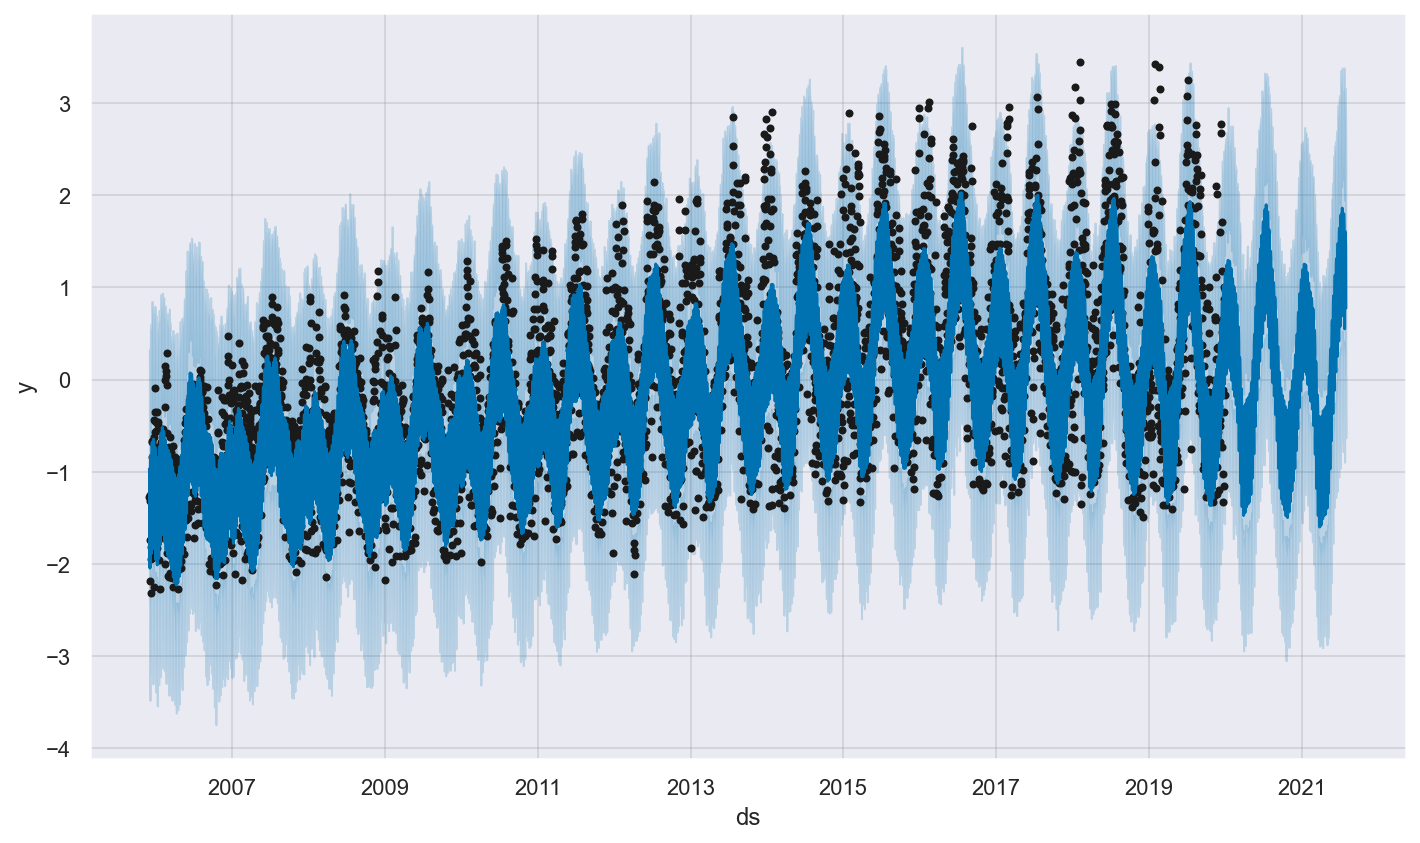

In [377]:
future = model.make_future_dataframe(periods=N_test)
forecast = model.predict(future)
fig=model.plot(forecast)

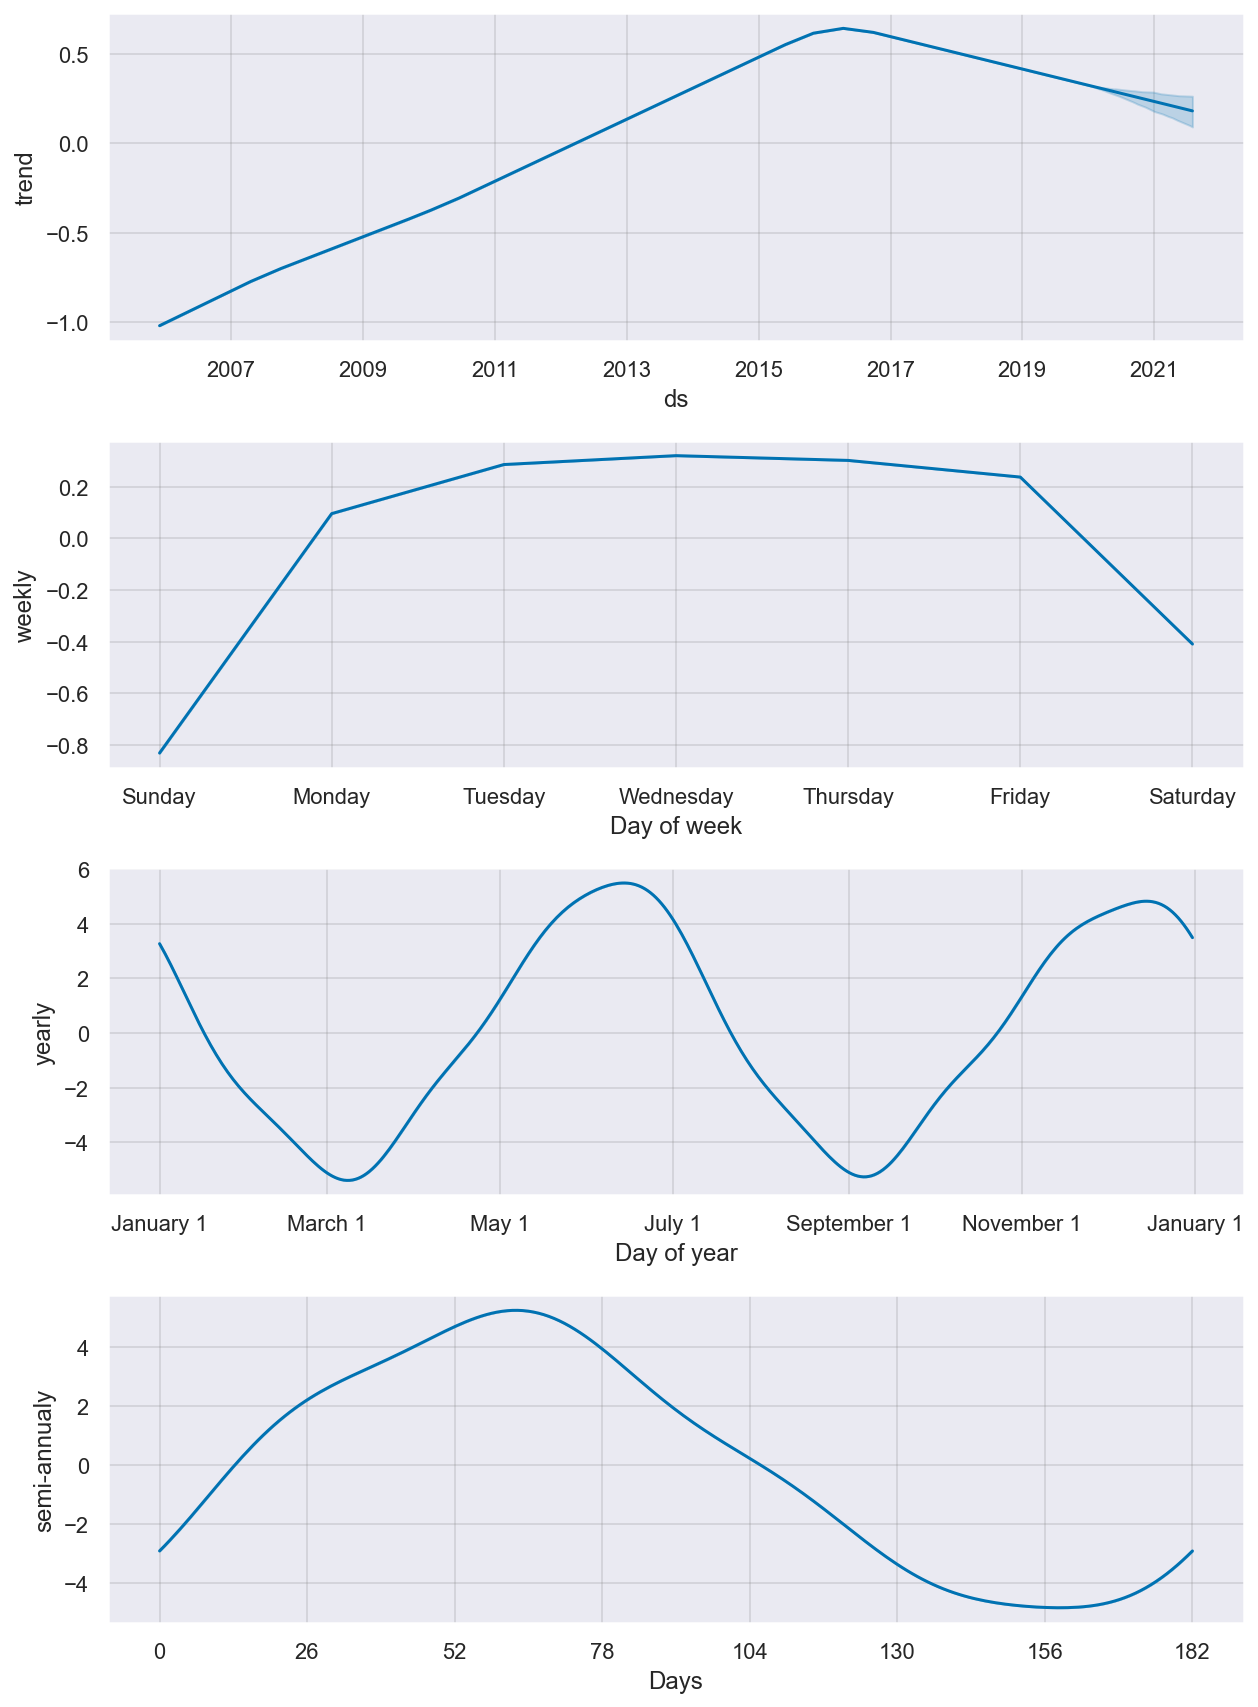

In [378]:
fig=model.plot_components(forecast)

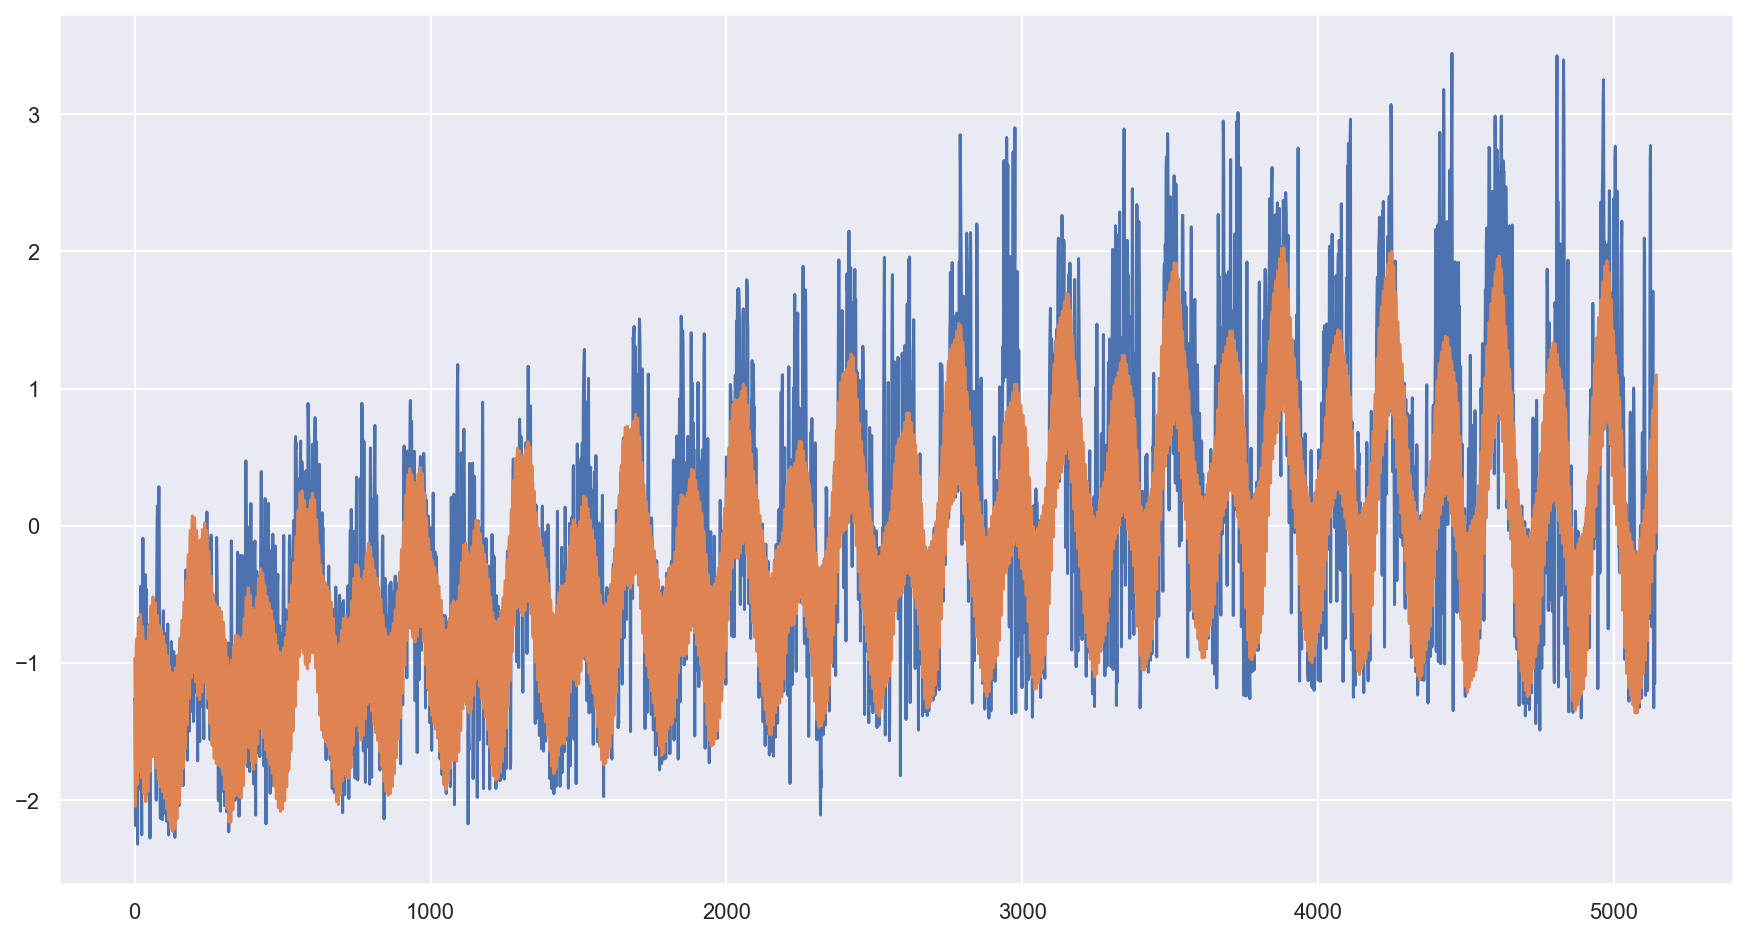

In [379]:
N=len(forecast)
y_fore=forecast['yhat']
y_fore_future=pd.DataFrame(y_fore[-N_test:])
y_fore_train=pd.DataFrame(y_fore[0:N-N_test])
plt.plot(train_set.y)
plt.plot(y_fore_train)

In [380]:
forecast.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5722 entries, 0 to 5721
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   ds                          5722 non-null   datetime64[ns]
 1   trend                       5722 non-null   float64       
 2   yhat_lower                  5722 non-null   float64       
 3   yhat_upper                  5722 non-null   float64       
 4   trend_lower                 5722 non-null   float64       
 5   trend_upper                 5722 non-null   float64       
 6   additive_terms              5722 non-null   float64       
 7   additive_terms_lower        5722 non-null   float64       
 8   additive_terms_upper        5722 non-null   float64       
 9   semi-annualy                5722 non-null   float64       
 10  semi-annualy_lower          5722 non-null   float64       
 11  semi-annualy_upper          5722 non-null   float64     

Amplio dataset a partir de la fecha

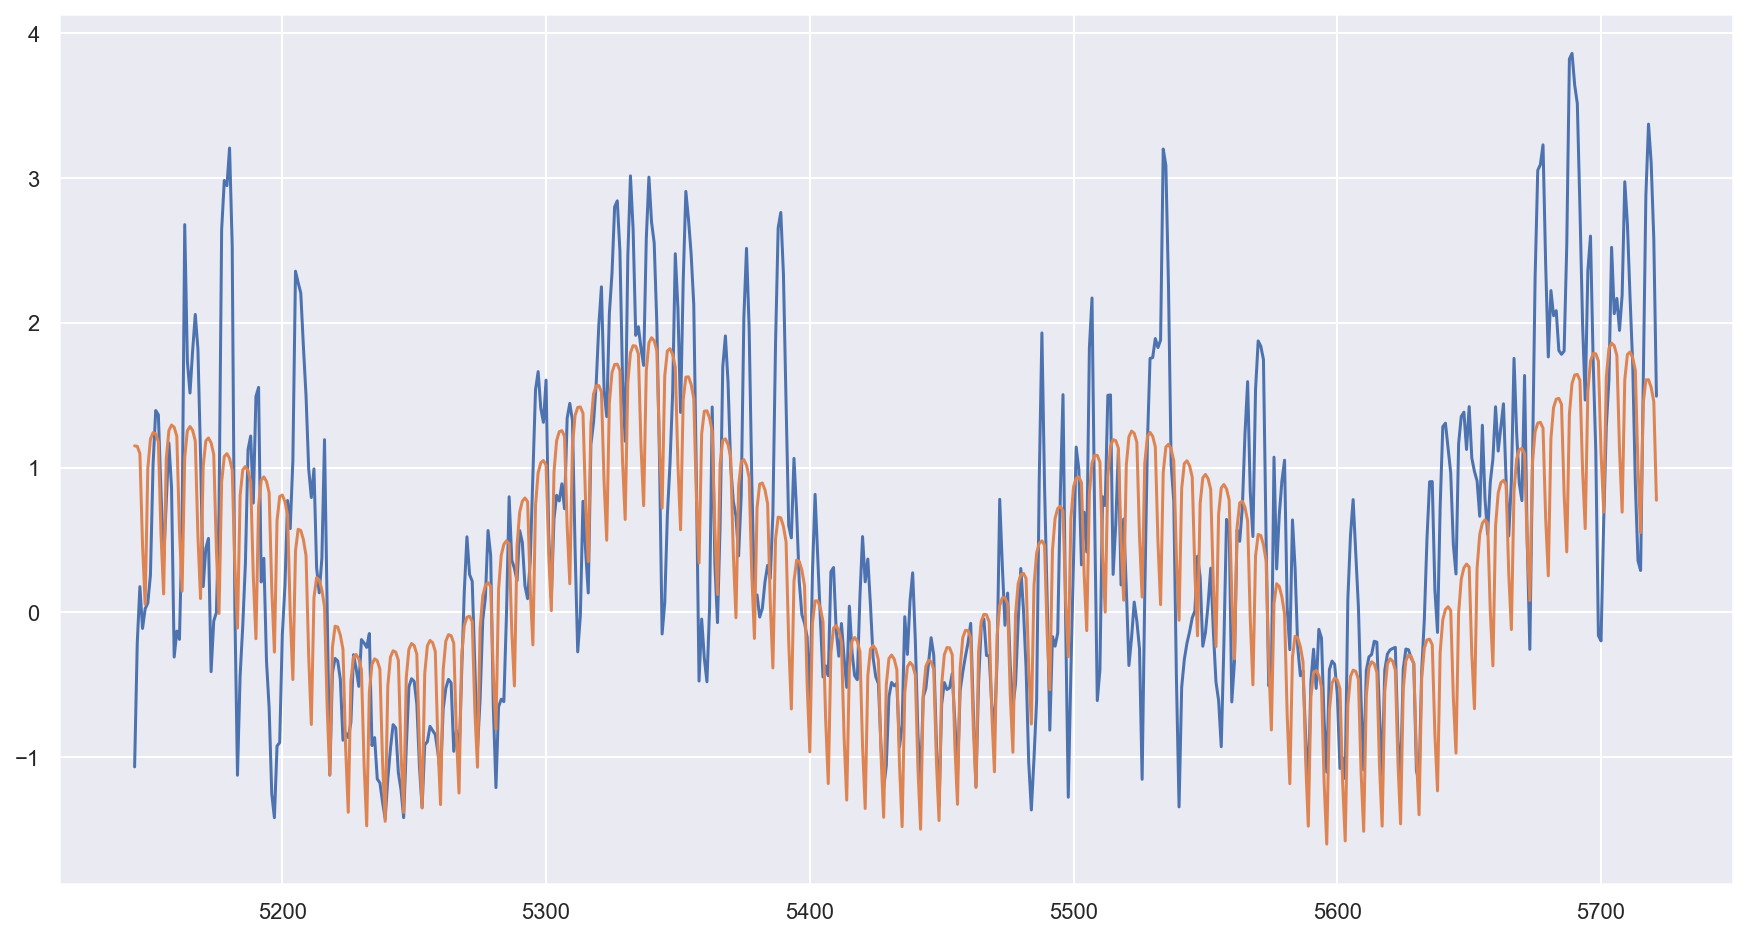

In [381]:
plt.plot(test_set.y)
plt.plot(y_fore_future)